In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python '/content/drive/My Drive/faceforensics_download_v4.py' -h

usage: faceforensics_download_v4.py [-h]
                                    [-d {original_youtube_videos,original_youtube_videos_info,original,DeepFakeDetection_original,Deepfakes,DeepFakeDetection,Face2Face,FaceShifter,FaceSwap,NeuralTextures,all}]
                                    [-c {raw,c23,c40}]
                                    [-t {videos,masks,models}] [-n NUM_VIDEOS]
                                    [--server {EU,EU2,CA}]
                                    output_path

Downloads FaceForensics v2 public data release.

positional arguments:
  output_path           Output directory.

optional arguments:
  -h, --help            show this help message and exit
  -d {original_youtube_videos,original_youtube_videos_info,original,DeepFakeDetection_original,Deepfakes,DeepFakeDetection,Face2Face,FaceShifter,FaceSwap,NeuralTextures,all}, --dataset {original_youtube_videos,original_youtube_videos_info,original,DeepFakeDetection_original,Deepfakes,DeepFakeDetection,Face2Face,Face

In [ ]:
!python '/content/drive/My Drive/faceforensics_download_v4.py' '/content/drive/My Drive/deepfake' -d DeepFakeDetection_original -c c23 -t videos

By pressing any key to continue you confirm that you have agreed to the FaceForensics terms of use as described at:
http://canis.vc.in.tum.de:8100/webpage/FaceForensics_TOS.pdf
***
Press any key to continue, or CTRL-C to exit.

Output path: /content/drive/My Drive/deepfake/original_sequences/actors/c23/videos
100% 363/363 [12:49<00:00,  2.12s/it]


In [ ]:
!python '/content/drive/My Drive/faceforensics_download_v4.py' '/content/drive/My Drive/deepfake/testset' -d DeepFakeDetection -c c23 -t videos --num_videos 

By pressing any key to continue you confirm that you have agreed to the FaceForensics terms of use as described at:
http://canis.vc.in.tum.de:8100/webpage/FaceForensics_TOS.pdf
***
Press any key to continue, or CTRL-C to exit.

Output path: /content/drive/My Drive/deepfake/testset/manipulated_sequences/DeepFakeDetection/c23/videos
  0% 7/3068 [00:10<1:21:22,  1.60s/it]Traceback (most recent call last):
  File "/content/drive/My Drive/faceforensics_download_v4.py", line 261, in <module>
    main(args)
  File "/content/drive/My Drive/faceforensics_download_v4.py", line 219, in main
    download_files(filelist, dataset_videos_url, dataset_output_path)
  File "/content/drive/My Drive/faceforensics_download_v4.py", line 104, in download_files
    download_file(base_url + filename, join(output_path, filename))
  File "/content/drive/My Drive/faceforensics_download_v4.py", line 131, in download_file
    urllib.request.urlretrieve(url, out_file_tmp)
  File "/usr/lib/python3.6/urllib/request.py

In [ ]:
/content/drive/My Drive/faceforensics_download_v4.py

In [ ]:
#shutil.rmtree('/content/cropped_face')

In [1]:
!pip install facenet-pytorch

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline 
import cv2 as cv
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

In [18]:
DATA_FOLDER = r'C:\Thesis\Dora\Dataset\LAB_dataset\video\Valid'
DATA_FOLDER_FAKE = r'C:\Thesis\Dora\Dataset\LAB_dataset\video\Valid\fake'
DATA_FOLDER_REAL = r'C:\Thesis\Dora\Dataset\LAB_dataset\video\Valid\real'
fake_videos = pd.DataFrame(list(os.listdir(DATA_FOLDER_FAKE)), columns=['Video'])
real_videos = pd.DataFrame(list(os.listdir(DATA_FOLDER_REAL)), columns=['Video'])

In [19]:
label = []
for e in fake_videos['Video']:
    label.append('fake')
fake_videos['Label'] = label

label2 = []
for e in real_videos['Video']:
    label2.append('real')
real_videos['Label'] = label2

In [20]:
fake_videos.head()

,Video,Label
0,實驗室-戴天佑-glasses+實驗室-尤耀慶-glasses.mp4,fake
1,實驗室-戴天佑-glasses+實驗室-尤耀慶-noglasses.mp4,fake
2,實驗室-戴天佑-glasses+實驗室-張育維-noglasses.mp4,fake
3,實驗室-戴天佑-glasses+實驗室-李冠霆-noglasses.mp4,fake
4,實驗室-戴天佑-glasses+實驗室-李約瑟-glasses.mp4,fake


In [21]:
train_videos = pd.concat([fake_videos,real_videos],join='outer',ignore_index= True)

train_list = list(os.listdir(os.path.join(DATA_FOLDER)))
json_file = [file for file in train_list if  file.endswith('json')][0]

def get_meta_from_json(path):
    df = pd.read_json(os.path.join(path, json_file))
    df = df.T
    return df

meta_train_df = get_meta_from_json(DATA_FOLDER)
meta_train_df.head()

In [22]:
train_videos.head

<bound method NDFrame.head of                                      Video Label
0      實驗室-戴天佑-glasses+實驗室-尤耀慶-glasses.mp4  fake
1    實驗室-戴天佑-glasses+實驗室-尤耀慶-noglasses.mp4  fake
2    實驗室-戴天佑-glasses+實驗室-張育維-noglasses.mp4  fake
3    實驗室-戴天佑-glasses+實驗室-李冠霆-noglasses.mp4  fake
4      實驗室-戴天佑-glasses+實驗室-李約瑟-glasses.mp4  fake
..                                     ...   ...
199                  實驗室-蔡佳吟-noglasses.mp4  real
200                    實驗室-鄭紹廷-glasses.mp4  real
201                  實驗室-鄭紹廷-noglasses.mp4  real
202                    實驗室-黃勤翔-glasses.mp4  real
203                  實驗室-黃勤翔-noglasses.mp4  real

[204 rows x 2 columns]>

In [24]:
def display_image_from_video(video_path):
    '''
    input: video_path - path for video
    process:
    1. perform a video capture from the video
    2. read the image
    3. display the image
    '''
    capture_image = cv.VideoCapture(video_path) 
    ret, frame = capture_image.read()
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    ax.imshow(frame)

def display_image_from_video_list(video_path_list):
    '''
    input: video_path_list - path for video
    process:
    0. for each video in the video path list
        1. perform a video capture from the video
        2. read the image
        3. display the image
    '''
    plt.figure()
    fig, ax = plt.subplots(2,2,figsize=(16,8))
    # we only show images extracted from the first 6 videos
    for i, video_file in enumerate(video_path_list):
        label = train_videos.loc[train_videos.Video == video_file, 'Label'].values[0]
        if label == 'fake':
            video_folder = DATA_FOLDER_FAKE
        elif label == 'real':
            video_folder = DATA_FOLDER_REAL
        video_path = video_folder+'/'+video_file
        print(video_path)
        capture_image = cv.VideoCapture(video_path) 
        ret, frame = capture_image.read()
        frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        ax[i//2, i%2].imshow(frame)
        ax[i//2, i%2].set_title(f"Video: {video_file}")
        ax[i//2, i%2].axis('off')

C:\Thesis\Dora\Dataset\LAB_dataset\video\Valid\fake/實驗室-羅振豪-glasses+實驗室-莊承恩-glasses.mp4
C:\Thesis\Dora\Dataset\LAB_dataset\video\Valid\fake/實驗室-戴天佑-noglasses+實驗室-莊承恩-noglasses.mp4
C:\Thesis\Dora\Dataset\LAB_dataset\video\Valid\fake/實驗室-戴天佑-glasses+實驗室-羅振豪-noglasses.mp4
C:\Thesis\Dora\Dataset\LAB_dataset\video\Valid\fake/實驗室-鄭紹廷-noglasses+實驗室-蔡佳吟-noglasses.mp4


<Figure size 432x288 with 0 Axes>

C:\Users\a0912\anaconda3\envs\gun\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 23526 (\N{CJK UNIFIED IDEOGRAPH-5BE6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\a0912\anaconda3\envs\gun\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 39511 (\N{CJK UNIFIED IDEOGRAPH-9A57}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\a0912\anaconda3\envs\gun\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 23460 (\N{CJK UNIFIED IDEOGRAPH-5BA4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\a0912\anaconda3\envs\gun\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 32645 (\N{CJK UNIFIED IDEOGRAPH-7F85}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\a0912\anaconda3\envs\gun\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 25391 (\N{CJK UNIFIED IDEOGRAPH-632F}) missing from c

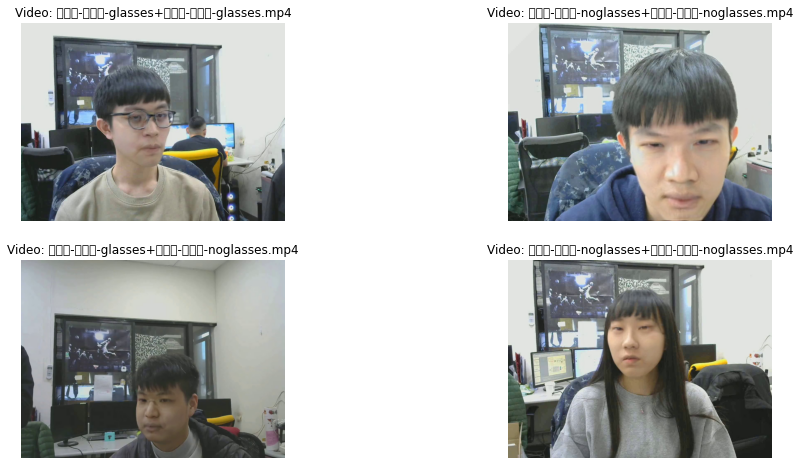

In [25]:
display_image_from_video_list(train_videos.sample(4).Video)

In [26]:
# Create face detector
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(margin=40, select_largest=False, keep_all=True, post_process=False, device=device)


In [27]:
def face_extraction_display(video_path_list):
    '''
    input: video_path_list - path for video
    process:
    0. for each video in the video path list
        1. perform a video capture from the video
        2. read the image
        3. display the image
    '''
    plt.figure()
    #fig, ax = plt.subplots(2,2,figsize=(16,8))
    # we only show images extracted from the first 6 videos
    for i, video_file in enumerate(video_path_list):
        label = train_videos.loc[train_videos.Video == video_file, 'Label'].values[0]
        if label == 'fake':
            video_folder = DATA_FOLDER_FAKE
        elif label == 'real':
            video_folder = DATA_FOLDER_REAL
        video_path = video_folder+'/'+video_file
        capture_image = cv.VideoCapture(video_path) 
        ret, frame = capture_image.read()
        frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        frame = Image.fromarray(frame)
        
        plt.figure(figsize=(12, 8))
        plt.imshow(frame)
        plt.axis('off')

        # Detect face
        faces = mtcnn(frame)
        
        # Visualize
      
        fig, ax = plt.subplots(2,2,figsize=(6,6))
        #for i, frame_faces in enumerate(faces):
        for j, face in enumerate(faces):
            ax[i,j].imshow(face.permute(1, 2, 0).int().numpy())
            ax[i,j].set_title(f"Video: {video_file}")
            ax[i,j].axis('off')
        fig.show()

C:\Users\a0912\AppData\Local\Temp/ipykernel_13200/4055542471.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 432x288 with 0 Axes>

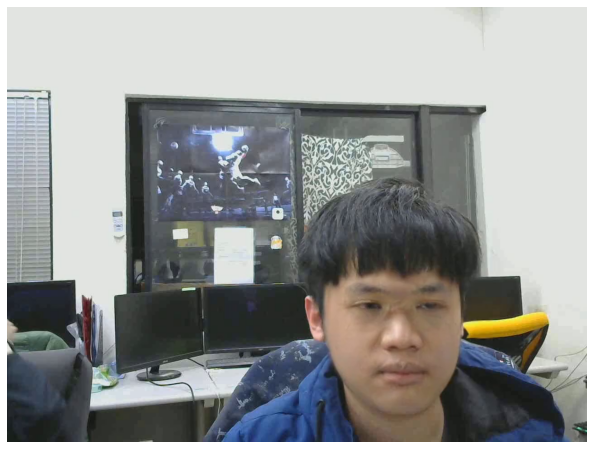

C:\Users\a0912\anaconda3\envs\gun\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 24373 (\N{CJK UNIFIED IDEOGRAPH-5F35}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\a0912\anaconda3\envs\gun\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 32946 (\N{CJK UNIFIED IDEOGRAPH-80B2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\a0912\anaconda3\envs\gun\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 32173 (\N{CJK UNIFIED IDEOGRAPH-7DAD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


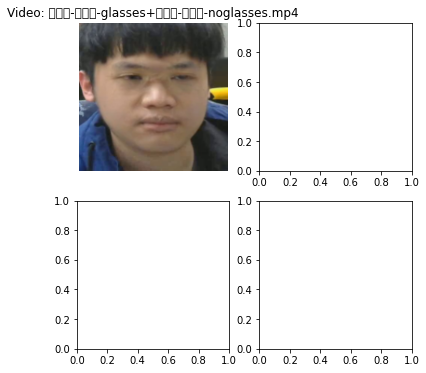

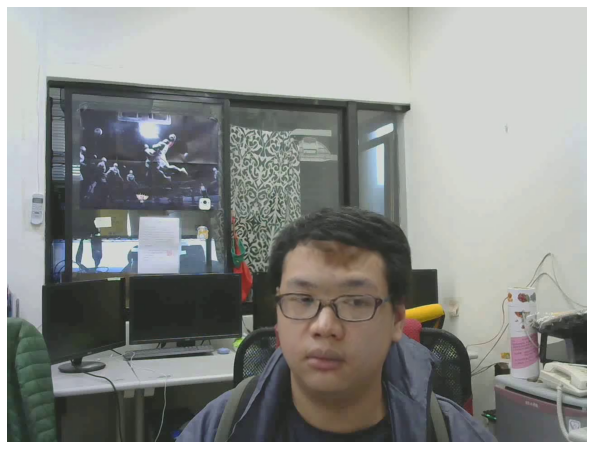

C:\Users\a0912\anaconda3\envs\gun\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 28504 (\N{CJK UNIFIED IDEOGRAPH-6F58}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\a0912\anaconda3\envs\gun\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 33707 (\N{CJK UNIFIED IDEOGRAPH-83AB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\a0912\anaconda3\envs\gun\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 21516 (\N{CJK UNIFIED IDEOGRAPH-540C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


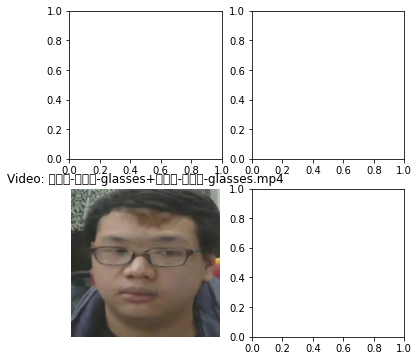

In [28]:
face_extraction_display(train_videos.loc[[2,6],'Video'])

In [29]:
def face_extraction(video_path_list):
    frames = []
    for i, video_file in enumerate(video_path_list):
        label = train_videos.loc[train_videos.Video == video_file, 'Label'].values[0]
        if label == 'fake':
            video_folder = DATA_FOLDER_FAKE
        elif label == 'real':
            video_folder = DATA_FOLDER_REAL
        video_path = video_folder+'/'+video_file
        capture_video = cv.VideoCapture(video_path)
        video_len = int(capture_video.get(cv.CAP_PROP_FRAME_COUNT)) 
        for j in tqdm(range(video_len)):
            # Load frame
            success = capture_video.grab()
            if j % 50 == 0:
                success, frame = capture_video.retrieve()
            else:
                continue
            if not success:
                continue
            # Add to batch
            frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
            #frames.append(Image.fromarray(frame))
            # Detect faces in batch
            if label == 'fake':
                save_paths = [r'C:\Thesis\Dora\Dataset\LAB_dataset\crop\Valid\fake/'+f'video_{i}'+f'frame_{j}.jpg']
            elif label == 'real':
                save_paths = [r'C:\Thesis\Dora\Dataset\LAB_dataset\crop\Valid\real/'+f'video_{i}'+f'frame_{j}.jpg']
            mtcnn(frame, save_path=save_paths);


In [30]:
face_extraction(train_videos['Video'])

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

In [31]:
del mtcnn

In [40]:
data_dir1 = r'C:\Thesis\Dora\Dataset\LAB_dataset\crop1'
data_dir2 = r'C:\Thesis\Dora\Dataset\LAB_dataset\crop2'
#data_dir3 = r'C:\Thesis\Dora\Dataset\LAB_dataset\crop\Valid\crop_f'
#data_dir4 = r'C:\Thesis\Dora\Dataset\LAB_dataset\crop\Valid\crop_r'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16
epochs = 50
workers = 0 if os.name == 'nt' else 8
np.random.seed(42)

In [41]:
from autoaugment import ImageNetPolicy
from torch.utils.data import random_split

trans1 = transforms.Compose([
    transforms.Resize(256),
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
trans2 = transforms.Compose([
    transforms.Resize(256),
    ImageNetPolicy(),
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
t = []
t.append(datasets.ImageFolder(data_dir1, trans1))
t.append(datasets.ImageFolder(data_dir2, trans2))
dataset_T = torch.utils.data.ConcatDataset(t)
'''v = []
v.append(datasets.ImageFolder(data_dir3, trans1))
v.append(datasets.ImageFolder(data_dir4, trans2))
dataset_V = torch.utils.data.ConcatDataset(v)'''
train_set_size = int(len(dataset_T) * 0.8)
valid_set_size = len(dataset_T) - train_set_size
train_set, valid_set = random_split(dataset_T, [train_set_size, valid_set_size])
#dataset = datasets.ImageFolder(data_dir, transform=trans)
#img_inds = np.arange(len(dataset))
#img_inds = np.random.shuffle(img_inds)
#train_inds = img_inds[:int(0.80 * len(img_inds))]
#val_inds = img_inds[int(0.80 * len(img_inds)):]
# split_inds = img_inds[int(0.80 * len(img_inds)):]
# test_inds = split_inds[int(0.50 * len(split_inds)):]
# val_inds = split_inds[:int(0.50 * len(split_inds))]

train_loader = DataLoader(
    train_set,
    num_workers=workers,
    batch_size=batch_size,
    shuffle=True
)
val_loader = DataLoader(
    valid_set,
    num_workers=workers,
    batch_size=batch_size
)
# test_loader = DataLoader(
#     dataset,
#     num_workers=workers,
#     batch_size=batch_size,
#     sampler=SubsetRandomSampler(test_inds)
# )
#shutil.rmtree('/content/cropped_face/.ipynb_checkpoints')

In [6]:
#test_inds

In [7]:
#test_data = []
#for i in test_inds:
 # test_data.append(dataset[i])


In [42]:
print('training data:',len(train_inds),'validating data:',len(val_inds))
# print('training data:',len(train_inds),'validating data:',len(val_inds),'testing data:',len(test_inds))

NameError: name 'train_inds' is not defined

In [9]:
dataset.class_to_idx

AttributeError: 'ConcatDataset' object has no attribute 'class_to_idx'

In [10]:
from collections import Counter

# print(dict(Counter(dataset.targets)))
print(dict(Counter(train_loader.targets)))
print(dict(Counter(val_loader.targets)))

AttributeError: 'DataLoader' object has no attribute 'targets'

In [43]:
from  elaInceptionResnet import ElaInceptionResnet

In [44]:
elanet = ElaInceptionResnet(
    classify=True,
    num_classes=2,
    device=device
).to(device)

In [14]:
len(dataset.class_to_idx)

AttributeError: 'ConcatDataset' object has no attribute 'class_to_idx'

In [25]:
#import shutil

#shutil.rmtree('/content/cropped_face')

In [45]:
optimizer = optim.Adam(elanet.parameters(), lr=0.0005)
scheduler = MultiStepLR(optimizer, [10,15])
loss_fn = torch.nn.CrossEntropyLoss().to(device)
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}
checkpoint = torch.load(r"C:\Users\a0912\OneDrive\桌面\Thesis\Models\ELAInceptionResnet_all\elainceptionresnet_statedict.pt", map_location='cpu')
elanet.load_state_dict(checkpoint)

<All keys matched successfully>

In [46]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
# resnet.eval()
# training.pass_epoch(
#     resnet, loss_fn, val_loader,
#     batch_metrics=metrics, show_running=True, device=device,
#     writer=writer
# )

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    elanet.train()
    training.pass_epoch(
        elanet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    elanet.eval()
    training.pass_epoch(
        elanet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )
writer.close()



Initial
----------

Epoch 1/50
----------
Train |   132/132  | loss:    2.8135 | fps:   35.2858 | acc:    0.6191   
Valid |    33/33   | loss:    2.5697 | fps:   59.4509 | acc:    0.0133   

Epoch 2/50
----------
Train |   132/132  | loss:    0.0548 | fps:   35.5436 | acc:    0.9815   
Valid |    33/33   | loss:    0.0010 | fps:   59.2853 | acc:    1.0000   

Epoch 3/50
----------
Train |   132/132  | loss:    0.0044 | fps:   35.1099 | acc:    1.0000   
Valid |    33/33   | loss:    0.0018 | fps:   59.2416 | acc:    1.0000   

Epoch 4/50
----------
Train |   132/132  | loss:    0.0020 | fps:   35.5358 | acc:    1.0000   
Valid |    33/33   | loss:    0.0009 | fps:   58.9337 | acc:    1.0000   

Epoch 5/50
----------
Train |   132/132  | loss:    0.0016 | fps:   34.9973 | acc:    1.0000   
Valid |    33/33   | loss:    0.0010 | fps:   58.9661 | acc:    1.0000   

Epoch 6/50
----------
Train |    11/132  | loss:    0.0012 | fps:   35.2930 | acc:    1.0000   

KeyboardInterrupt: 

In [47]:
PATH = r'C:\Users\a0912\OneDrive\桌面\Thesis\Models\ELAInceptionResnet_all\weight\lab_all.pt'
torch.save(elanet.state_dict(), PATH)

In [ ]:
print('training data: 14366 validating data: 3190 testing data: 2420')

training data: 14366 validating data: 3190 testing data: 2420


In [ ]:
Initial
----------
Valid |    51/51   | loss:    0.7873 | fps:   12.5668 | acc:    0.4596   

Epoch 1/8
----------
Train |   401/401  | loss:    0.5900 | fps:    3.9235 | acc:    0.7020   
Valid |    51/51   | loss:    0.5717 | fps:   12.7864 | acc:    0.7065   

Epoch 2/8
----------
Train |   401/401  | loss:    0.4443 | fps:    3.9301 | acc:    0.7875   
Valid |    51/51   | loss:    0.3803 | fps:   12.9056 | acc:    0.8070   

Epoch 3/8
----------
Train |   401/401  | loss:    0.4363 | fps:    3.9168 | acc:    0.7977   
Valid |    51/51   | loss:    0.3795 | fps:   12.9544 | acc:    0.8039   

Epoch 4/8
----------
Train |   401/401  | loss:    0.3612 | fps:    3.9163 | acc:    0.8246   
Valid |    51/51   | loss:    0.3156 | fps:   12.4373 | acc:    0.8364   

Epoch 5/8
----------
Train |   401/401  | loss:    0.3413 | fps:    3.8742 | acc:    0.8335   
Valid |    51/51   | loss:    0.3266 | fps:   12.6135 | acc:    0.8352   

Epoch 6/8
----------
Train |   401/401  | loss:    0.2804 | fps:    3.9128 | acc:    0.8597   
Valid |    51/51   | loss:    0.2850 | fps:   12.6134 | acc:    0.8554   

Epoch 7/8
----------
Train |   401/401  | loss:    0.2521 | fps:    3.9080 | acc:    0.8712   
Valid |    51/51   | loss:    0.2774 | fps:   12.6196 | acc:    0.8615   

Epoch 8/8
----------
Train |   401/401  | loss:    0.2328 | fps:    3.9025 | acc:    0.8816   
Valid |    51/51   | loss:    0.2730 | fps:   12.4472 | acc:    0.8578   
Valid |    51/51   | loss:    0.2829 | fps:   12.3044 | acc:    0.8493   

same_original_fake_train_sample_video = list(meta_train_df.loc[meta_train_df.original=='xmkwsnuzyq.mp4'].index)
for video_file in same_original_fake_train_sample_video[1:4]:
    print(video_file)
    extract_image_and_face(video_file)